#Maze
Zadatak:
  - Dodati funkcionalna teleport polja
  - Implementirati algoritam iteracija po Q vrednostima umesto po V vrednostima
  - Implementirati algoritam iteritranja po politikama za Q i za V vrednosti
  - Vizualizacija
  - Izmeniti domaci 1 tako da je Maze graf, tako da je mdp stohasticki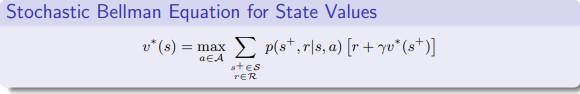



#Definisanje osnovnih pojmova
Umesto polja koja smo imali u obicnom Maze-u ovde je potrebno implementirati cvorove koji ce zadrzati osobine prethodnih polja, sa dodatkom atributa pozicije jer nju vise ne proveravamo kretanjem u lavirintu.

Svaki od cvorova moze biti terminal, wall, regular, ili teleport.

In [ ]:
import random as rdm
from abc import ABC, abstractmethod
from copy import copy

import numpy as np
import matplotlib.pyplot as plt

from random import random, choice

import networkx as nx
from prettytable import PrettyTable

In [ ]:
class Node(ABC):
    def __init__(self, x: int, y: int):
        self.x = x
        self.y = y

    def get_position(self) -> tuple:
        return (self.x, self.y)
    #implemetira se za svako polje koje nasledjuje klasu drugacije tako da za sta stavljamo pass
    @abstractmethod
    def get_reward(self) -> float:
        pass

    def is_steppable(self) -> bool:
        return True

    def is_terminal(self) -> bool:
        return False

    def has_value(self) -> bool:
        return True

In [ ]:
class RegularNode(Node):
    #ima neku nagradu
    def __init__(self, reward: float, x: int, y: int):
        super().__init__(x, y)
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward

In [ ]:
class TerminalNode(Node):
    def __init__(self, reward: float, x: int, y: int):
        super().__init__(x, y)
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward

    def is_terminal(self) -> bool:
        return True
    #nema vrednost
    def has_value(self) -> bool:
        return False

In [ ]:
class WallNode(Node):
    def __init__(self, x: int, y: int):
        super().__init__(x, y)

    def get_reward(self) -> float:
        return 0

    def is_steppable(self) -> bool:
        return False

    def has_value(self) -> bool:
        return False

In [ ]:
class TeleportNode(Node):
    def __init__(self, reward: float, x: int, y: int):
        super().__init__(x, y)
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward

Iz svakog cvora mozemo se kretati u vidu 3 akcije:

In [ ]:
ACTIONS = [1, 2, 3]

##Maze Environment
Okruzenje Maze-a u vidu grafa gde svaki cvor odgovara stanju u grafu. Okruzenje je inicijalizovano zadatom velicinom i cvorovima raznih, prethodno definisanih vrsta. Maze je sastavljen kao graf, gde su cvorovi medjusobno povezani i imaju verovatnoce prelaska sa jednom u drugi akcijama.
U klasi se nalaze metode za:

*   inicijalizaciju grafa
*   definisanje verovatnoca prelaska iz jednog cvora u drugi
*   povratne informacije o Maze-u

Atributi:
- graph_height (int) daje visinu maze-a
- graph_width (int) daje sirinu maze-a
- recnik koji zakljuceve ima cvorove, a vrednosti su liste akcija i cvorova sa kojima je povezan

In [ ]:
class MazeEnvironment:
    def __init__(self, dimensions: tuple[int, int]):
        #inicijalizujemo velicinu lavirinta
        self.graph_height = dimensions[0]
        self.graph_width = dimensions[1]
        self.graph = self.initialize_graph(self.graph_height, self.graph_width)

    def initialize_graph(self, width: int, height: int) -> dict:
        #inicijalizujemo graf koji predstavlja lavirint
        graph = {}
        terminal_node_created = False

        for w in range(1, width + 1):
            for h in range(1, height + 1):
                node = self.generate_random_node(w, h)
                graph[node] = []
                #da li imamo terminalni cvor
                if isinstance(node, TerminalNode):
                    terminal_node_created = True

        #ako nemamo nas zadatak uospte tema smisla tako da ga stavljamo na randmo mesto, umesto nekog cvora koji NIJE zid
        if not terminal_node_created:
            non_wall_nodes = [n for n in graph.keys() if not isinstance(n, WallNode)]
            node_to_replace = choice(non_wall_nodes)
            terminal_node = TerminalNode(-1, node_to_replace.x, node_to_replace.y)
            graph.pop(node_to_replace)
            graph[terminal_node] = []

        #postavljamo verovatnoca prelaska iz jednog u drugi cvor
        for node in graph:
            graph[node] = self.set_probabilities(node, graph)

        return graph

    def set_probabilities(self, node: Node, graph: dict) -> list:
        #postavljamo verovatnoce prelaska, ali postujemo odredjena pravila
        #1. cvorovi tipa Wall i Terminal nemaju verovatnoce prelaska u neki drugi cvor, dok se za Regular i Teleport imaju
        #2. iako je stohasticki model, ne zelimo da moze da se skoci u bas bilo koji cvor zato za pola covrova dajemo 0 sansu prelaska u njih


        #Terminal i Wall node nemaju verovatnoce
        if isinstance(node, (WallNode, TerminalNode)):
            return []
        #za ostale koji nisu zid
        nodes_list = [n for n in graph if not isinstance(n, WallNode)]
        probabilities = []

        #racunamo broj funkcionalnih cvorova koje ce imati nultu verovatnocu
        total_cells = self.graph_width * self.graph_height
        #minimalna vrednost od broja cvorova koji nisu Wall i 0.5 ukupnog broja cvorova, da ne bi mogao da ode u bilo koji drugi cvor
        zero_cells = min(len(nodes_list), total_cells // 2)

        #dodeljujemo nultu verovatnocu cvorovima koji nisu Teleport, a ni Wall jer su oni vec van nodes_list
        if not isinstance(node, TeleportNode):
            for _ in range(zero_cells):
                random_node = rdm.choice(nodes_list)
                nodes_list.remove(random_node)
                probabilities.append([0, random_node, 0])

        # rasporedli ostale cvorove akcijama
        for action in ACTIONS:
            if nodes_list:
                #broj cvorova za dodelu svakoj akciji, mora biti bar 1
                action_len = len(nodes_list) // len(ACTIONS) or 1
                nodes_for_action = nodes_list[:action_len]
                nodes_list = nodes_list[action_len:]

                non_zero_probabilities = self.generate_probabilities(nodes_for_action)
                for node, prob in zip(nodes_for_action, non_zero_probabilities):
                    probabilities.append([action, node, prob])
        return probabilities

    @staticmethod
    def generate_random_node(w: int, h: int) -> Node:
        """
        Generisemo random cvor, sa odredjenim sansama, tako da je naravno Regularan najucestaliji:
        - RegularNode sa nagradom -1: 10/18 vrv (~55.56%)
        - RegularNode nagrade -10: 2/18 vrv (~11.11%)
        - TerminalNode: 2/18 vrv (~11.11%), nema nagrade
        - WallNode: 2/18 vrv (~11.11%)
        - TeleportNode: 2/18 vrv (~11.11%)
        """
        prob = rdm.randint(1, 18)
        if prob < 11:
            return RegularNode(-1, w, h)
        elif prob < 13:
            return RegularNode(-10, w, h)
        elif prob < 15:
            return TerminalNode(-1, w, h)
        elif prob < 17:
            return WallNode(w, h)
        else:
            return TeleportNode(-2, w, h)

    @staticmethod
    def generate_probabilities(cells: list) -> np.ndarray:
        probabilities = np.random.rand(len(cells))
        #normalizujemo
        probabilities /= sum(probabilities)
        #sada je ukupna suma 1
        return probabilities

    def print_graph(self):
        #prikazuje graf, u matricnom formatu, sa pozicijama, akcijama i vrednostima
        values_graph = {}
        for node in self.graph:
            values_graph[node.get_position()] = []
            for [action, next_node, prob] in self.graph[node]:
                values_graph[node.get_position()].append(
                    [action, next_node.get_position(), prob]
                )
        self.print_values(values_graph)
        return

    def print_values(self, g: dict):
        #ispisujemo vrednosti grafa
        # g je recnik gde je kljuc pozicija cvora, a vrednost je lista akcija, pozicija sledeceg cvog i verovatnoca
        print(
            "\n----------------------------------------------- MAZE GRAF "
            "------------------------------------------------ "
        )
        print(" ")
        for node in g:
            if self.get_current_pos_node(node).get_reward() == -10:
                print(node, "* : ", g[node])  # za regular bez kazne
                print(" ")
            else:
                print(node, ": ", g[node])
                print(" ")
        return

    @staticmethod
    def is_terminal(node: Node) -> bool:

        return node.is_terminal()

    def is_terminal_pos(self, position: tuple) -> bool:

        return self.get_current_pos_node(position).is_terminal()

    def get_graph(self) -> dict:

        return self.graph

    def get_current_pos_node(self, pos: tuple) -> Node:

        for node in self.graph:
            if node.get_position() == pos:
                return node
        raise Exception("Invalid position given.")

    def random_not_wall(self, nodes: list, depth: int = 0, max_depth: int = 20) -> Node:
        #vraca random cvor, koji nije Wall, a ako jeste rukurizvno se poziva ova funkcija opet, sve dok nije ili se ne dostigne maksimalna dubina rekurzije koja je predefinisana sa 20
        if depth > max_depth:
            raise RecursionError("Maximum depth recursion je dostignut u random_not_wall funkciji")

        random_node = rdm.choice(nodes)
        if isinstance(random_node, WallNode):
            return self.random_not_wall(nodes, depth + 1, max_depth)

        return random_node

    def get_action_probabilities(self, node: Node, action: int) -> list:

        #Vraca listu tupleova koji sadrze sledeci cvor i vrv da se dodje iz trenutnog cvora, za zadatu akciju

        action_probabilities = []
        for transition in self.graph[node]:
            transition_action, next_node, probability = transition
            if transition_action == action:
                action_probabilities.append((next_node, probability))

        return action_probabilities

    def get_next_node(self, nodes_probs: list) -> Node:
        #biramo cvor na osnovu liste verovatnoca
        if not nodes_probs or not any(prob for _, prob in nodes_probs):
            #vrati prvi cvor u listi kao default ili neki predefinisan cvor
            return nodes_probs[0][0] if nodes_probs else self.get_default_node()

        probabilities = [probability for _, probability in nodes_probs]
        # uzmi random indeks prema rasprostranjenosti verovatnoca, gde svaki indeks odgovara cvoru sa iz action_probabilities
        index = np.random.choice(len(probabilities), p=probabilities)
        return nodes_probs[index][0]

    def get_default_node(self):
        # vrati prvi cvor iz grafa
        return next(iter(self.get_graph()), None)

##Bojanje cvorova
Regularan cvor je siv, kazneni je crven, zid je crn, terminalni je plav, u oslalim slucajevima je zelen, kao npr. u slicaju da je teleport.

In [ ]:
def get_node_color(cell: Node) -> str:
    if isinstance(cell, RegularNode) and cell.get_reward() == -10:
        return "red"
    elif isinstance(cell, RegularNode) and cell.get_reward() == -1:
        return "gray"
    elif isinstance(cell, WallNode):
        return "black"
    elif isinstance(cell, TerminalNode):
        return "blue"
    else:
        return "green"

In [ ]:
def plot_maze_graph(env: MazeEnvironment):
    #ploltujemo okruzenje, ali Wall nema grane ni ka njemu ni iz njega
    g = nx.DiGraph()
    graph = env.get_graph()
    edge_labels = {}
    pos = {}  # mesto, recnik, gde belezimo pozicije
    offset = 0.1  # za podesavanje labela grana
    action_colors = {
        1: "magenta",
        2: "orange",
        3: "cyan"
    }

    teleport_edges = []  # lista sa granama iz teleporta
    normal_edges = []  # lista koja ima ostale grane

    for node in graph:
        position = node.get_position()
        pos[node] = position
        g.add_node(node, pos=position)

        if not isinstance(node, WallNode):
            for action, next_node, probability in graph[node]:
                if (action != 0 and probability != 0 and not isinstance(next_node, WallNode)):
                    edge_color = action_colors.get(action, "black")
                    if isinstance(node, TeleportNode):
                        teleport_edges.append((node, next_node, edge_color))
                    else:
                        normal_edges.append((node, next_node, edge_color))
                    edge_labels[(node, next_node)] = f"{next_node.get_reward()}"

    # crtanje covorova
    node_colors = {node: get_node_color(node) for node in g.nodes()}
    node_color_list = [node_colors[node] for node in g.nodes()]
    plt.figure(figsize=(10, 7))
    nx.draw_networkx_nodes(g, pos, node_color=node_color_list, node_size=700)

    # crtanje normalnih grana
    for source, target, color in normal_edges:
        nx.draw_networkx_edges(
            g,
            pos,
            edgelist=[(source, target)],
            edge_color=color,
            arrowstyle="->",
            arrowsize=30,
            connectionstyle="arc3,rad=0.2",
        )

    # crtanje teleport grana, one su isprekidane
    for source, target, color in teleport_edges:
        nx.draw_networkx_edges(
            g,
            pos,
            edgelist=[(source, target)],
            edge_color=color,
            style="dashed",
            alpha=0.5,
            arrowstyle="->",
            arrowsize=30,
            connectionstyle="arc3,rad=0.2",
        )

    node_labels = {node: f"{pos[node]}" for node in g.nodes()}
    nx.draw_networkx_labels(g, pos, labels=node_labels, font_color="white")

    # podesevanje labela pozicije za labele grana
    edge_labels_pos = {
        edge: [
            (pos[edge[0]][0] + pos[edge[1]][0]) / 2 + offset,
            (pos[edge[0]][1] + pos[edge[1]][1]) / 2 + offset,
        ]
        for edge in edge_labels
    }

    for edge, new_pos in edge_labels_pos.items():
        label = edge_labels[edge]
        plt.text(new_pos[0], new_pos[1], label, fontsize=10, color="red")

    # sta je koji cvor, legenda kao
    node_type_colors = {
        "Regular Node": "gray",
        "Terminal Node": "blue",
        "Wall Node": "black",
        "Teleport Node": "green",
    }
    node_legends = [
        plt.Line2D([0], [0], color=color, marker="o", linestyle="", markersize=10)
        for color in node_type_colors.values()
    ]
    action_legends = [
        plt.Line2D([0], [0], color=color, marker="", linestyle="-")
        for color in action_colors.values()
    ]

    legend1 = plt.legend(
        node_legends, node_type_colors.keys(), title="Node Types", loc="upper left"
    )
    plt.gca().add_artist(legend1)
    plt.legend(
        action_legends,
        [f"Action {a}" for a in action_colors.keys()],
        title="Actions",
        loc="lower left",
    )

    plt.axis("off")
    plt.show()





##Iteriranje

###Iteriranje po vrednostima

Procena Q-vrednosti i V-vrednosti obavlja se pozivom funkcije value_iteration.
Funkcija azurira ove vrednosti sve dok greska ne postane manja od odredjenog praga ili dok se ne dostigne maksimalan broj iteracija (maxit).
Tokom svake iteracije (asinhrono azuriranje), poziva se ili update_q_value ili update_v_value u zavisnosti od toga da li se procenjuju Q-vrednosti ili V-vrednosti. U ovim funkcijama, koriste se Bellmanove jednačine za izracunavanje optimalnih vrednosti.

Proces pronalaženja optimalne politike sprovodi se pozivom generate_optimal_policy, koji vraća politiku kao rečnik:

```
dict[position] = optimal_action
```
Parametar q_function se takođe prilagođava da li je politika zasnovana na V-vrednostima ili Q-vrednostima.
Unutar ove funkcije, za svako stanje poziva se greedy_action kako bi se izvela politika.

###Iteriranje po politikama

Funkcija policy_iteration koristi se za izvrsavanje algoritma iteriranja po politikama.
Opet, parametar q_function odredjuje da li algoritam koristi Q-vrednosti ili V-vrednosti.
Unutar ove funkcije, petlja se izvrsava dok dve uzastopne politike ne budu iste.
Inicialno, procenjuje V-vrednosti ili Q-vrednosti za datu politiku, a zatim formira pohlepnu politiku na osnovu ovih procenjenih vrednosti.

Ovaj proces se ponavlja dok ne dođe do konvergencije politika.

##Inicijalizacije V vrednosti

In [ ]:
def init_v_values(env: MazeEnvironment) -> dict:
    #incijalna vrednost netreminalnih cvorova je random negativna vrednost, dok je vrednost terminalnog cvora 0
    #kao izlaz imamo dict. sa kljucem kao tupple sa pozicijama, a vrednsti recnika su inicijalne v vrednosti

    return {node.get_position(): -20 * random() if not env.is_terminal(node) else 0 for node in env.get_graph()}


##Inicijalizacije Q vrednosti
Q-vrednosti predstavljaju ocekivanu korist od preuzimanja odredjdene akcije u odredjenom stanju i sledenja optimalne politike nakon toga.

Q-vrednosti se inicijalizuju na isti način, kao i v vrednosti.

In [ ]:
def init_q_values(env: MazeEnvironment) -> dict:
    q_values = {}
    for node in env.get_graph():
        for action in ACTIONS:
            if env.is_terminal(node):
                q_values[node.get_position(), action] = 0
            else:
                q_values[node.get_position(), action] = -20 * random()
    return q_values



#Funkcija calculate_v_values
Racuna v vrednost za cvor koristeci Bellmanovu jednacinu za stohasticko okruzenje. Formula:

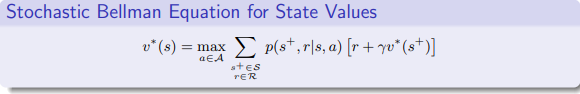


Notacija:

 V(s) vrednost u stanju s,

 a akcija,

 P(s'|s, a) je verovatnoca prelaska iz stanja s u s' preko akcije a,

 R(s, a, s') je nagrada koja se dobije prelaskom s->s' akcijom a,

 γ je gamma faktor obezvredjivanja,

 V(s') vrednost sledeceg stanja.

 Ova funkcija racuna ocekivanu korist svake akcije na datom cvoru i vraca maksimum ovih vrednosti.

In [ ]:
def calculate_v_value(
    env: MazeEnvironment, position: tuple, values: dict, gamma: float
) -> float:
    # ulazni argumenti su pozicija cvora, trenutni recnik v vrednosti i gamma
    # izlaz je nova v vrednost za taj cvor, ako je zid u pitanju onda je fiksna velika negativna vrednost

    node_at_position = env.get_current_pos_node(position)
    action_values = []  # belezi izracunatu vrednost za svaku akciju

    for action in ACTIONS:
        value_for_action = 0
        for next_node, transition_probability in env.get_action_probabilities(
            node_at_position, action
        ):
            future_value = values[next_node.get_position()]
            reward = next_node.get_reward()
            value_for_action += transition_probability * (reward + gamma * future_value)

        action_values.append(value_for_action)

    # odabere najvecu vrednost od svih
    # ako je zid daj -100
    return max(action_values) if max(action_values) != 0 else -100

#Funkcija calculate_q_value

kao i kod v_vrednosti racuna na bellmanovoj jednacini za q ucenje.
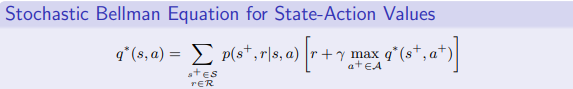


Notacija:

 Q(s,a) q vrednost akcije a u stanju s

P(s'|s, a) je verovatnoca prelaska s->s' u akciji a

R(s, a, s') je nagrada primljena posle s->s' sa akcijom a,

max_a'{ Q(s', a') } predstavlja maximum q vrednost za sledece s' stanje iz svih dostupnih akcija a'


In [ ]:
def calculate_q_value(
    env: MazeEnvironment, state: tuple, values: dict, gamma: float
) -> float:

    node_at_state = env.get_current_pos_node(state[0])
    action_value_contributions = []

    for next_node, transition_prob in env.get_action_probabilities(
        node_at_state, state[1]
    ):
        future_values = [
            values[next_node.get_position(), next_action] for next_action in ACTIONS
        ]
        best_future_value = max(future_values)
        reward = next_node.get_reward()

        value_contribution = transition_prob * (reward + gamma * best_future_value)
        action_value_contributions.append(value_contribution)
    return sum(action_value_contributions) if action_value_contributions else -100

#Asinhrono azuriranje vrednosti
Ova funkcija vrši asinhrono azuriranje svih vrednosti (V ili Q) za jednu iteraciju u algoritmu iteracije po vrednosti ili Q-ucenja.

Ova funkcija iterira kroz sve parove stanja-akcija (za Q vrednosti) ili sva stanja (za iteraciju po vrednosti) u okruzenju i azurira njihove vrednosti na osnovu trenutnih procena.

Azuriranje je **'asinhrono'** jer se vrednosti azuriraju jedna po jedna, i svako azuriranje koristi najnovije vrednosti.

Prilikom azuriranja Q-vrednosti (q_function=True), funkcija izracunava Q-vrednost za svaki par stanja-akcije gde stanje nije terminalno, koristeci funkciju calculate_q_value. To ukljucuje procenu ocekivane koristi svakog moguceg sledeceg stanja iz datog para stanje-akcija.

Prilikom ažuriranja V-vrednosti (q_function=False), funkcija izracunava V-vrednost za svako ne-terminalno stanje koristeci funkciju calculate_v_value. To ukljucuje pronalazenje maksimalne ocekivane koristi preko svih mogucih akcija iz tog stanja.


In [ ]:
def async_update_all_values(
    env: MazeEnvironment, values: dict, gamma: float, q_function: bool
) -> dict:
    for state_action_pair in values:
        if q_function:
            # kad update radimo, provera da nije u pitanju terminal
            if not env.is_terminal_pos(
                state_action_pair[0]
            ):
                values[state_action_pair] = calculate_q_value(
                    env, state_action_pair, values, gamma
                )
        else:
            # kad updateujemo v vrednosti, stanje je zapravo pozicija
            position = (
                state_action_pair  # ovde je to, pozicija je zapravo stanje
            )
            if not env.is_terminal_pos(position):
                values[position] = calculate_v_value(env, position, values, gamma)

    return values

Iteriranje kroz politike i iteriranje kroz vrednosti predstavljaju dva različita pristupa u učenju pojačanja (RL), svaki sa svojim implikacijama i primenama:

**Iteriranje kroz Politike:**
  - U algoritmima iteracije politike, fokus je na iterativnom poboljšanju politike direktno.
Proces uključuje evaluaciju trenutne politike i zatim njeno poboljšanje.

  - Algoritmi iteracije politike se smenjuju između ova dva koraka sve dok ne konvergiraju, rezultirajući politikom koja je optimalna ili blizu optimalne.

  - Cilj je pronaći najbolju politiku koja maksimizira očekivanu kumulativnu nagradu tokom vremena.


**Iteriranje kroz Vrednosti:**

  - U algoritmima iteracije vrednosti, fokus je na iterativnom poboljšanju funkcije vrednosti, koja predstavlja očekivanu kumulativnu nagradu iz svakog stanja ili par stanje-akcija.

  - Proces uključuje iterativno ažuriranje funkcije vrednosti dok ne konvergira ka optimalnoj funkciji vrednosti.

  - Kada se pronađe optimalna funkcija vrednosti, politika se može izvesti biranjem akcija koje maksimiziraju očekivanu kumulativnu nagradu na osnovu trenutnih procena vrednosti.
  
  - Iteracija vrednosti direktno optimizuje funkciju vrednosti umesto politike, a politika se izvodi iz funkcije vrednosti kada se ona konvergira.

U suštini, iteriranje kroz politike predstavlja **direktan** pristup i direktno azuzira politiku , dok iteriranje kroz vrednosti predstavlja **indirektan** pristup i fokusira na poboljšanje funkcije vrednosti, iz koje sledi izvođenje optimalne politike.

Oba pristupa imaju za cilj pronalaženje optimalne ili blizu optimalne politike, ali se razlikuju po svojim osnovnim mehanizmima i računarskim postupcima.

###Iteriranje po vrednostima


In [ ]:
def value_iteration(
    env: MazeEnvironment,
    gamma: float,
    convergence_threshold: float,
    max_iterations: int = 100,
    use_q_function: bool = False,
) -> tuple:

    current_values = init_q_values(env) if use_q_function else init_v_values(env)
    for iteration_number in range(max_iterations):
        previous_values = copy(current_values)
        updated_values = async_update_all_values(
            env, current_values, gamma, use_q_function
        )
        max_error = max(
            abs(updated_values[state] - previous_values[state])
            for state in current_values
        )

        if max_error < convergence_threshold:
            return updated_values, iteration_number + 1

        current_values = updated_values

    return current_values, iteration_number + 1


Odlucuje najbolju akciju ako su iste vrednosti.

Ako je vrednost za obe akcije 1 i 2 jednaka -1 onda vraca prvu.

In [ ]:
def best_action_min_arg(actions_probs: list) -> int:
    max_probability = max(prob for _, prob in actions_probs)
    max_probability_elements = [
        (action, prob) for action, prob in actions_probs if prob == max_probability
    ]

    min_action = min(action for action, _ in max_probability_elements)
    min_action_element = [
        (action, prob)
        for action, prob in max_probability_elements
        if action == min_action
    ][0][0]

    return min_action_element

#Greedy akcija
Odlucuje koja je to najbolja akcija za izvrsiti u trenutnom cvoru na pohlapan nacin.

Ova funkcija izracunava ocekivanu korist za svaku mogucu akciju iz trenutnog cvora i bira akciju koja maximizuje tu ocekivanu korist.

In [ ]:
def greedy_action(
    env: MazeEnvironment,
    current_node: Node,
    values: dict,
    gamma: float,
    use_q_values: bool = False,
) -> int:
    action_values = []
    #iteracija kroz akcije
    for action in ACTIONS:
      #reset koristi
        expected_utility = 0
        #idemo kroz sledece cvorove
        for next_node, transition_prob in env.get_action_probabilities(
            current_node, action
        ):
            if use_q_values:
                future_values = [
                    values[next_node.get_position(), next_action]
                    for next_action in ACTIONS
                ]
                best_future_value = max(future_values)
            else:
                best_future_value = values[next_node.get_position()]

            expected_utility += transition_prob * (
                next_node.get_reward() + gamma * best_future_value
            )

        action_values.append((action, expected_utility))

    # vraca tu najbolju akciju
    return best_action_min_arg(action_values) if action_values else None



Generise optimalnu politiku za nase maze okruzenje na osnovu date V ili Q vrednosti.

Politika je mapiranje pozicije svakog cvora na najbolju akciju odredjenu pohlepnom strategijom, koja maximizuje ocekivanu korist na osnovu trenutnih procena vrednosti (V ili Q vrednosti).



In [ ]:
def generate_optimal_policy(
    env: MazeEnvironment, values: dict, gamma: float, use_q_values: bool = False
) -> dict:
    optimal_policy = {}
    for node in env.get_graph():
        if not (node.is_terminal() or not node.is_steppable()):
            node_position = node.get_position()
            best_action = greedy_action(env, node, values, gamma, use_q_values)
            optimal_policy[node_position] = best_action

    return optimal_policy

Random politika. idi u neko random stanje iz trenutnog.

In [ ]:
def generate_random_policy(env: MazeEnvironment) -> dict:
    policy = {}
    for s in env.get_graph():
        policy[s.get_position()] = rdm.choice(ACTIONS)
    return policy

##Procena Q i V vredosti

In [ ]:
def evaluate_values(
    env: MazeEnvironment,
    policy: dict,
    gamma: float,
    convergence_threshold: float,
    use_q_values: bool = False,
) -> dict:
    current_values = init_q_values(env) if use_q_values else init_v_values(env)
    updated_values = copy(current_values)

    while True:
        for state in current_values:
            node = env.get_current_pos_node(state[0] if use_q_values else state)

            if isinstance(node, WallNode):
                updated_values[state] = -100
            elif isinstance(node, TerminalNode):
                updated_values[state] = 0
            else:
                chosen_action = policy[node.get_position()]
                transition_probs = env.get_action_probabilities(node, chosen_action)

                if use_q_values:
                    update_state_value_q(
                        state, updated_values, transition_probs, gamma, policy
                    )
                else:
                    update_state_value_v(state, updated_values, transition_probs, gamma)

        max_error = max(
            abs(updated_values[s] - current_values[s]) for s in current_values
        )
        if max_error < convergence_threshold:
            return updated_values

        current_values = updated_values

#Update state value Q
Azurira Q vrednosti za dati par stanje - ackija za datu politiku.
Ova funkcija se koristi u trazenju najbolje politike i iterativno azurira Q vrednosti za svaki par stanje- akcija na osnovu TRENUTNE politike.

Azurirana vrednost se izracunava uzimajuci u obzir ocekivanu korist akcije koja je zavisna o politici u sledecem stanju.

Q vrednost se azurira na sledeci način:

Q(s, a) = R(s, a, s') + γ * Q(s', policy(s'))

In [ ]:
def update_state_value_q(state, values, transition_probs, gamma, policy):
    """    Args:
        state (tuple);
        values (dict): dict sa trenutnim Q vrednostima za svaki stanje - akcija par;
        transition_probs (list): lista taplova sledece_stanje, verovatnoca ;
        gamma (float);
        policy (dict): trenutna politika koju gledamo, ona zapravo mapira stanja akcijama
nema izlaza jer ovo samo azurira vec postojece q vrednosti
    """
    #prolaz kroz sledeca stanja i njihove verovatnoce
    for next_node, prob in transition_probs:
        if isinstance(next_node, TerminalNode):
            values[state] = next_node.get_reward()
            #sledeca akcija zavisi od politike
        else:
            next_action = policy[next_node.get_position()]
            #racunamo dobit
            values[state] = (
                next_node.get_reward()
                + gamma * values[next_node.get_position(), next_action]
            )

#Update state value V
Azurira V vrednosti za dato stanje za bas tu prosledjenu politiku.

iterativno azurira v vrednosti za svako stanje na osnovu trenutne politike. azurirana vrednost se racuna sumom ocekivanih koristi za sva moguca sledeca stanja, ponderisanih njihovim tranzicionim verovatnocama(verovatnocama da predju u sledece stanje) i  akcijama odredjenim politikom.


V vrednost se azurira po formuli:
        V(s) = Σ [ P(s'|s, politika(s)) * (R(s, politika(s), s') + γ * V(s')) ]

In [ ]:
def update_state_value_v(state, values, transition_probs, gamma):

    value_sum = 0
    for next_node, prob in transition_probs:
        value_sum += prob * (
            next_node.get_reward() + gamma * values[next_node.get_position()]
        )
    values[state] = value_sum

#Pohlepna Politika
Daje greedy politiku na osnovu datih vrednosti iz Q ili V tabele.
Prima Maze, recnik Vrednosti (ili Q ili V moze oba) i na osnovu njih donosi greedy akciju. Prima i GAMMU i neki boolean kojim govorima jel radimo sa q ili v vrednostima.

In [ ]:
def greedy_policy(env, values, gamma, q_function):
    return generate_optimal_policy(env, values, gamma, q_function)

#Iteriranje po politikama
Izvrsava algoritam iteriranja po pilitikama ne bi li nasao optimalnu politiku za dato okruzenje Maze koje saljemo. Nas algoritam kroz iteracije ocenjuje/vrednuje politiku i poboljsava je na osnovu trenutne procene sve dok ne izkonvergira u optimalnu politiku.

In [ ]:
def policy_iteration(
    env: MazeEnvironment,
    gamma: float,
    convergence_threshold: float,
    use_q_values: bool = False,
) -> dict:
    """
    Izlaz:
        dict: optimalna politika kao dict gde su kljucevi pozicije a vrednosti su akcije.
    """
    current_policy = generate_random_policy(env)
    while True:
        value_estimates = evaluate_values(
            env, current_policy, gamma, convergence_threshold, use_q_values
        )
        improved_policy = greedy_policy(env, value_estimates, gamma, use_q_values)

        if improved_policy == current_policy:
            return current_policy

        current_policy = improved_policy


  Algoritam se moze testirati sa različitim dimenzijama mazea, ali je vazno osigurati da je broj akcija adekvatno mali.
  Npr, graf dimenzija 2x2 ne može imati 4 akcije, jer je implementacija dizajnirana tako da svaki čvor povezuje polovinu drugih
  čvorova. (na pocetku smo to definisali kad smo pravili grane). Zbog toga, broj akcija ne sme premasiti polovinu ukupnog broja cvorova.
  Ovo ogranicenje ne vazi za vece grafove.


----------------------------------- GOTOV ALGORITAM ITERIRANJA PO VREDNOSTIMA -----------------------------------

Konacne V vrednosti po iteracijama za broj iteracija: 3
+----------+------------+
| Pozicija | V vrednost |
+----------+------------+
|  (1, 1)  |    -1.0    |
|  (1, 2)  |   -2.71    |
|  (1, 3)  |     0      |
|  (2, 1)  |    -1.0    |
|  (2, 2)  |    -1.0    |
|  (2, 3)  |    -1.9    |
|  (3, 1)  |    -1.9    |
|  (3, 2)  |    -1.0    |
|  (3, 3)  |    -1.9    |
+----------+------------+

Konacne Q vrednosti posle iteracija za broj iteracija: 5
+---------------+--------------------+
| Stanje-Akcija |     Q vrednost     |
+---------------+--------------------+
|  ((1, 1), 1)  |        -1.9        |
|  ((1, 1), 2)  |       -4.439       |
|  ((1, 1), 3)  |        -1.0        |
|  ((1, 2), 1)  | -2.876774320287054 |
|  ((1, 2), 2)  | -8.51693140953471  |
|  ((1, 2), 3)  |       -2.71        |
|  ((1, 3), 1)  |         0          |
|  ((1, 3), 2)  |         0          |
|  

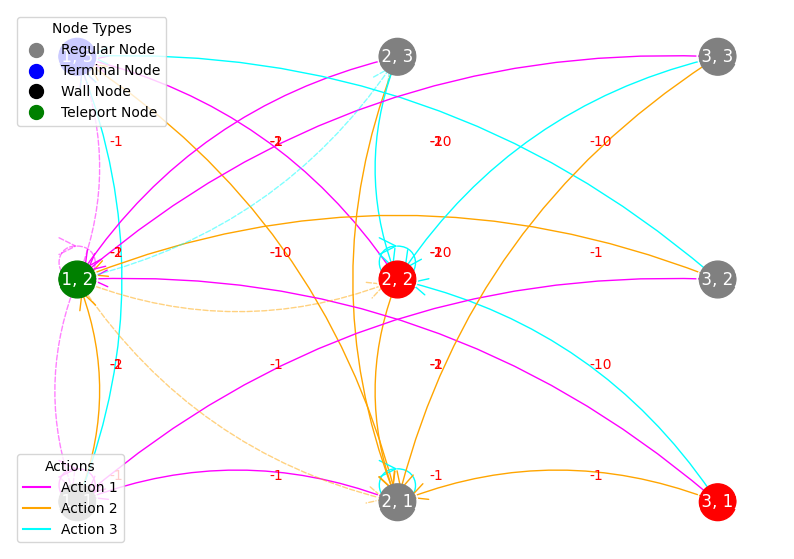

In [ ]:
#dimenzije grafa
dims = (3, 3)
#okruzenje
en = MazeEnvironment(dims)

#izlazi value)iterations su current_values i iteracija+1
v, v_it = value_iteration(en, 0.9, 0.01)
q, q_it = value_iteration(en, 0.9, 0.01, use_q_function=True)

# V tabela
v_table = PrettyTable()
v_table.field_names = ["Pozicija", "V vrednost"]
for position, value in v.items():
    v_table.add_row([position, value])

print(
    "\n----------------------------------- GOTOV ALGORITAM ITERIRANJA PO VREDNOSTIMA -----------------------------------\n"
)
print(f"Konacne V vrednosti po iteracijama za broj iteracija: {v_it}")
print(v_table)

# Q values table
q_table = PrettyTable()
q_table.field_names = ["Stanje-Akcija", "Q vrednost"]
for state_action, value in q.items():
    q_table.add_row([state_action, value])

print(f"\nKonacne Q vrednosti posle iteracija za broj iteracija: {q_it}")
print(q_table)

optimal_pol_v = generate_optimal_policy(en, v, 0.9)
optimal_pol_q = generate_optimal_policy(en, q, 0.9, use_q_values=True)

# Optimalna politika posle iteriranja V vrednosti
optimal_v_table = PrettyTable()
optimal_v_table.field_names = ["Pozicija", "Optimalna Akcija"]
for position, action in optimal_pol_v.items():
    optimal_v_table.add_row([position, action])

print(
    "\n---------------------------------- Optimalna Politika posle iteriranja po vrednostima ---------------------------------\n"
)
print("Optimalna politika posle iteriranja kroz V vrednosti je:")
print(optimal_v_table)

# Optimalna politika za Q tabelu
optimal_q_table = PrettyTable()
optimal_q_table.field_names = ["Pozicija", "Optimalna akcija"]
for position, action in optimal_pol_q.items():
    optimal_q_table.add_row([position, action])

print("\nOptimalna politika posle iteriranja kroz Q tabelu:")
print(optimal_q_table)

optimal_pol_pi_v = policy_iteration(en, 0.9, 0.01)
optimal_pol_pi_q = policy_iteration(en, 0.9, 0.01, use_q_values=True)

# Iteriranje politikama kroz V vrednosti
pi_v_table = PrettyTable()
pi_v_table.field_names = ["Pozicija", "Optimalna Akcija"]
for position, action in optimal_pol_pi_v.items():
    pi_v_table.add_row([position, action])

print(
    "\n---------------------------------- Optimalna akcija po iteriranju kroz V vrednosti --------------------------------\n"
)
print("Optimalna politika posle iteriranja politikama za V je :")
print(pi_v_table)

# Iteriranje politikama Q
pi_q_table = PrettyTable()
pi_q_table.field_names = ["Pozicija", "Optimalna Akcija"]
for position, action in optimal_pol_pi_q.items():
    pi_q_table.add_row([position, action])

print("\Optimalna politika posle iteracije politikama koriscenjem Q:")
print(pi_q_table)

print("\n Boje akcija:  \n1 - roze, \n2 - narandzasta, \n3 -  plava\n")

print("\n\n Boje Cvorova:  \nKazneno - crveno, \nRegularno - sivo, \nWall -  crno, \nTerminal plavo \nNeki drugi cvor - zeleno \n")
en.print_graph()
plot_maze_graph(en)